In [1]:
#Coding With Qiskit S2E7 Shor's Algorithm

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import *
from qiskit.aqua.algorithms import Shor
from qiskit.aqua import QuantumInstance
import numpy as np
import pandas as pd
from fractions import Fraction

In [2]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1000)

my_shor=Shor(N=15,a=2,quantum_instance=quantum_instance)

Shor.run(my_shor)

{'factors': [[3, 5]], 'total_counts': 70, 'successful_counts': 20}

In [3]:
def c_amod15(a,power): #modular exponentiation function, hard coded for factorizing 15, guess number 7
    U = QuantumCircuit(4)
    for iteration in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    U=U.to_gate() #turns the circuit into a gate to use later
    U.name="%i^%i mod 15" %(a,power)
    c_U = U.control()
    return c_U

In [4]:
n_count = 8 
a = 7 

In [5]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit,n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)),m,j) #replaced cu1 with cp gate due to deprec warning
        qc.h(j)
    qc.name="QFT dagger"
    return qc

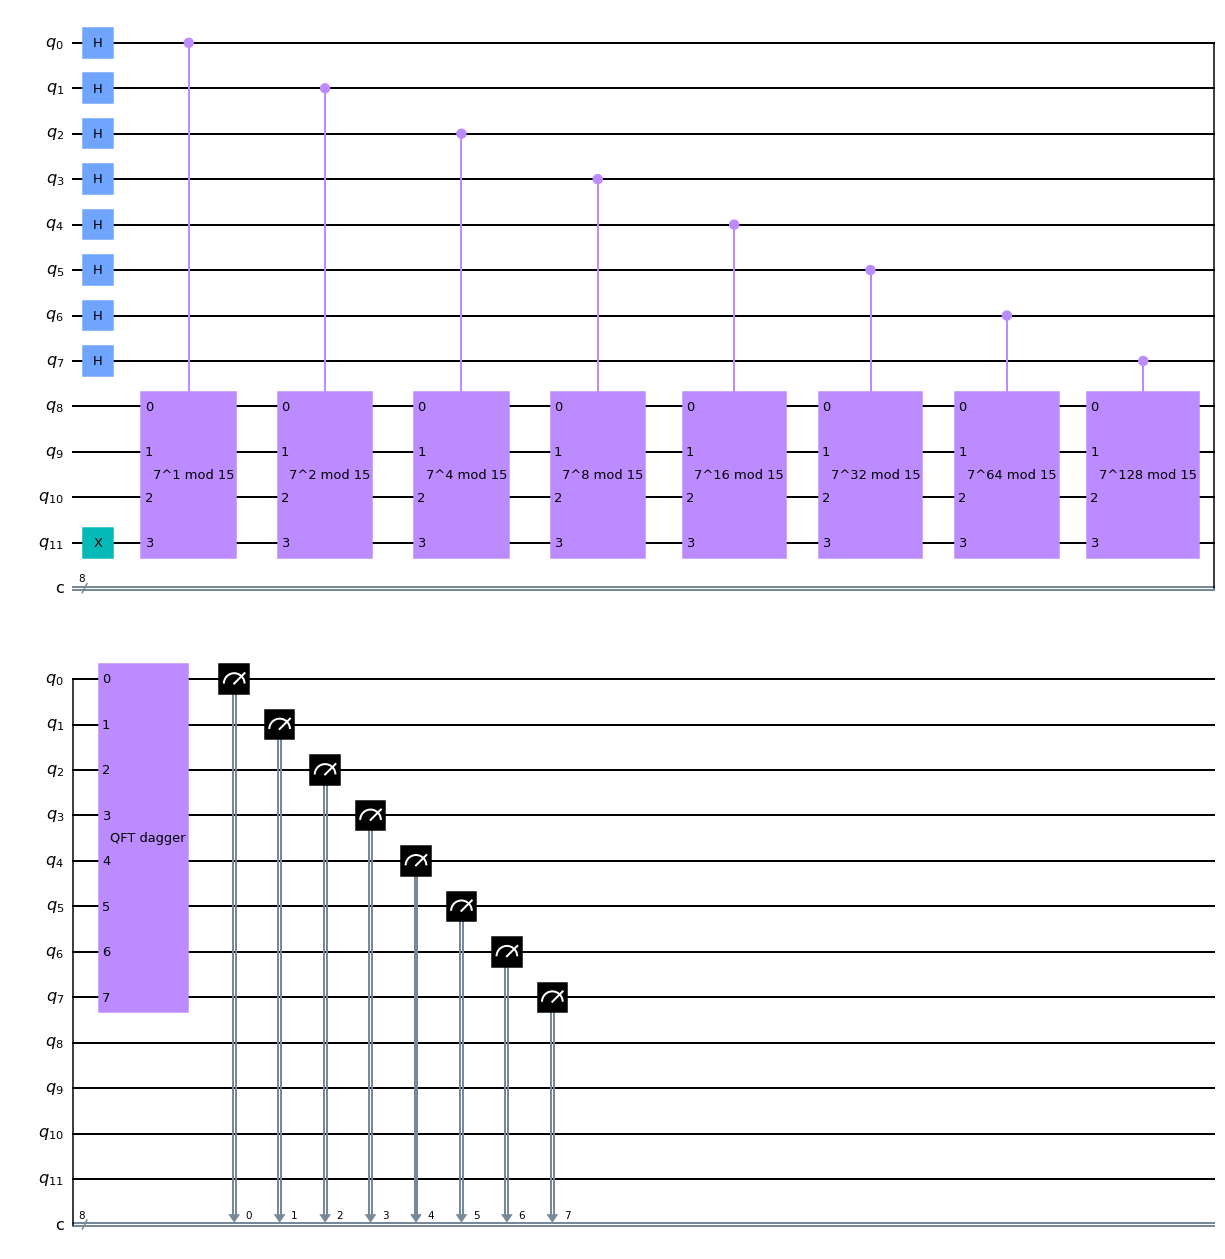

In [6]:
qc = QuantumCircuit(n_count + 4, n_count) #4 ancilla

for q in range(n_count): #intialize counting qubits into superposition state
    qc.h(q)

qc.x(3+n_count) #initialize first ancilla in the excited state

for q in range(n_count):
    qc.append(c_amod15(a,2**q), [q]+[i+n_count for i in range(4) ])

qc.append(qft_dagger(n_count), range(n_count))

qc.measure(range(n_count), range(n_count))

qc.draw()

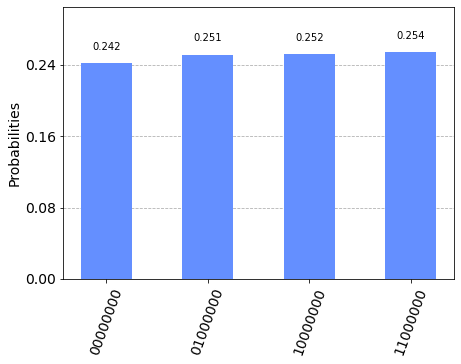

In [7]:
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

In [8]:
#phases of 0/256, 64/256, 128/256, 192/256
#gives guesses for r of 1,2,4
#plug into p=a^(r/2)-1, q=a^(r/2)+1
#for r = 4: p=48, q=50
#p has a common factor with N=15 of 3
#q has a common factor with of 5

In [9]:
#the rest is taken from the qiskit textbook https://qiskit.org/textbook/ch-algorithms/shor.html

In [10]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0    00000000(bin) = 0(dec)    0/256 = 0.00
1   01000000(bin) = 64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [11]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4
